In [1]:
# import necessary packages
import sys, os, glob
import torch
import matplotlib.pyplot as plt
import networkx as nx

from IPython.display import clear_output
from torch_geometric.nn import Node2Vec
from sklearn.manifold import TSNE
from torch_geometric.utils.convert import to_networkx, from_networkx
from torch_geometric.datasets import Planetoid
from tqdm.notebook import tqdm
from importlib import reload

sys.path.append('../')

# custom imports
from utils.GetLowestGPU import GetLowestGPU
from utils.GetFileNames import get_file_names
import utils.preprocessing as pp

In [2]:
device = GetLowestGPU()

Device set to cuda:0


## Load Data

In [3]:
# options
network_path = "../data/networks/DREAM4/DREAM4_in-silico_challenge/Size_10/DREAM4_gold_standards/"
graph_names = get_file_names(network_path, ".tsv")

In [4]:
# view graph names
graph_names

['insilico_size10_4_goldstandard.tsv',
 'insilico_size10_5_goldstandard.tsv',
 'insilico_size10_1_goldstandard.tsv',
 'insilico_size10_3_goldstandard.tsv',
 'insilico_size10_2_goldstandard.tsv']

In [5]:
# convert graphs to node/edge lists and then nx objects
graphs = []
for name in tqdm(graph_names):
    # convert to nx object and append
    graphs.append(from_networkx(pp.convert_to_nx(network_path + name)))
print(f"Processed {len(graphs)} graphs!")

  0%|          | 0/5 [00:00<?, ?it/s]

Processed 5 graphs!


Pytorch Geometric has a nice [tutorial](https://colab.research.google.com/github/AntonioLonga/PytorchGeometricTutorial/blob/main/Tutorial11/Tutorial11.ipynb)

## Node2Vec

* pytorch geometric has [node2vec](https://pytorch-geometric.readthedocs.io/en/latest/tutorial/shallow_node_embeddings.html)

In [6]:
# dataset = 'Cora'
# path = os.path.join('.', 'data', dataset)
# dataset = Planetoid(path, dataset)
# data = dataset[0]

In [7]:
# extract test graph for node2vec
ex = graphs[0]
print(ex)

Data(edge_index=[2, 90], weight=[90], num_nodes=10)


In [8]:
# create node2vec model 
model = Node2Vec(ex.edge_index, embedding_dim=128, 
                 walk_length=20,                        # lenght of rw
                 context_size=10, walks_per_node=20,
                 num_negative_samples=1, 
                 p=200, q=1,                            # bias parameters
                 sparse=True).to(device)

### Create Dataloader

In [9]:
loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
for idx, (pos_rw, neg_rw) in enumerate(loader):
    print(idx, pos_rw.shape, neg_rw.shape)

0 torch.Size([2200, 10]) torch.Size([2200, 10])


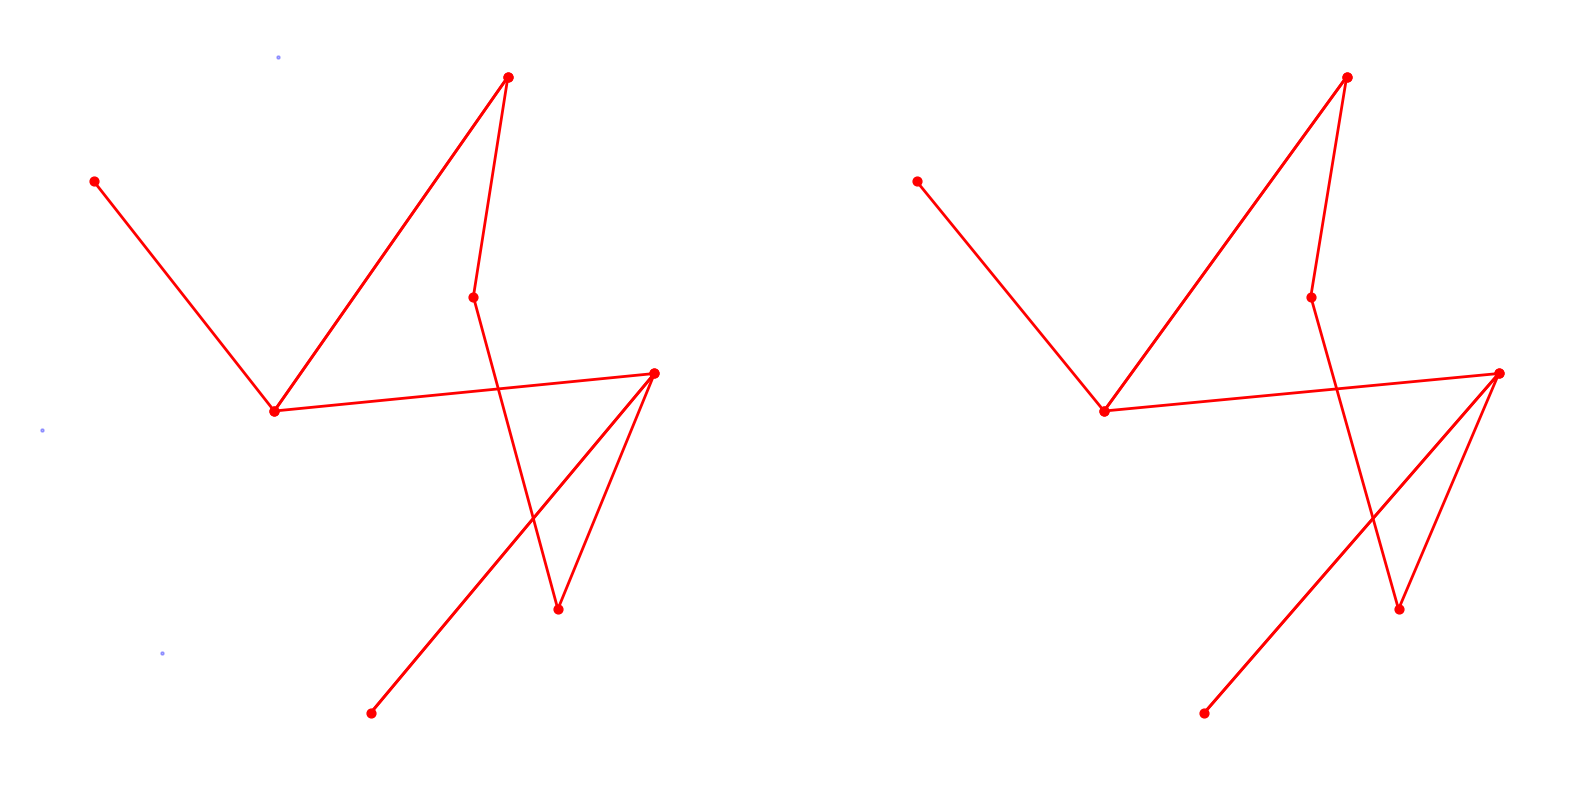

In [10]:
# visualize graph
edge_tuples = [tuple(x) for x in ex.edge_index.numpy().transpose()]
G = nx.from_edgelist(edge_tuples)
pos = nx.spring_layout(G, center=[0.5, 0.5])
nx.set_node_attributes(G, pos, 'pos')

# visualize random walk
nodelist = next(enumerate(loader))[1][0][0].tolist()
walk = nx.path_graph(len(nodelist))
nx.set_node_attributes(walk, {idx: pos[node_id] for idx, node_id in enumerate(nodelist)}, 'pos')


fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1)
nx.draw_networkx_nodes(G, 
                       ax=ax,
                       pos=nx.get_node_attributes(G, 'pos'), 
                       node_size=5,
                       alpha=0.3,
                       node_color='b')

nx.draw(walk, 
        node_size=40,
        node_color='r',
        ax=ax,
        pos=nx.get_node_attributes(walk, 'pos'), 
        width=2,
        edge_color='r') 
ax = fig.add_subplot(1, 2, 2)

nx.draw(walk, 
        node_size=40,
        node_color='r',
        ax=ax,
        pos=nx.get_node_attributes(walk, 'pos'), 
        width=2,
        edge_color='r') 

In [11]:
# training
model = Node2Vec(ex.edge_index, embedding_dim=128, walk_length=20,
                 context_size=10, walks_per_node=10,
                 num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

In [12]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [13]:
# run training loop
for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}', end='\r')

In [18]:
# test a singular embedding
model.eval()
model(ex.edge_index.to(device)).shape

torch.Size([2, 90, 128])

## Graph AutoEncoder

* torch geometric also has [GAE](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.models.GAE.html)

## GCN

## GraphLLM Embedding

* As seen in [GraphLLM Paper](https://arxiv.org/abs/2310.05845)